In [1]:
!pip install pandahouse
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandahouse: filename=pandahouse-0.2.7-py2.py3-none-any.whl size=5921 sha256=7471c85ddfa3d0680aabc940fa4e07120816715f6aa020c00600e338d8b605b1
  Stored in directory: /root/.cache/pip/wheels/a5/21/86/0baf87a3ad07ced200fa982d25162c82bb099114382cdeaa46
Successfully built pandahouse
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 85 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.7 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6639209 sha256=c0d215aa512bf2fcebd3da065e0fd02b9dbc951e000b659

In [4]:
#
import pandahouse as ph

connection = dict(database='default',
                  host='http://clickhouse.beslan.pro:8080',
                  user='student',
                  password='dpo_python_2020')

query = '''
-- Sales by day --
SELECT CAST(BuyDate AS Date) AS ds, sum(Rub) AS y
FROM checks  AS l
LEFT JOIN (SELECT * FROM devices) AS r ON l.UserID=r.UserID
GROUP BY ds
ORDER BY ds ASC
'''

ts = ph.read_clickhouse(query=query, connection=connection)
ts

,ds,y
0,2019-01-01,536831
1,2019-01-02,1434828
2,2019-01-03,1701914
3,2019-01-04,2023772
4,2019-01-05,2228740
...,...,...
272,2019-09-30,2052391
273,2019-10-01,2090499
274,2019-10-02,2069107
275,2019-10-03,2161355


### Prophet

In [5]:
# Library
import pandas as pd 
import numpy as np
from datetime import date
import holidays
from fbprophet import Prophet

In [6]:
print(ts['ds'].min())
print(ts['ds'].max())

2019-01-01 00:00:00
2019-10-04 00:00:00


In [7]:
# import holidays
#holidays_dict = holidays.Russia(years=(2019))
holidays_dict = holidays.Ukraine(years=(2019))
holidays_dict

{datetime.date(2019, 1, 1): 'Новий рік', datetime.date(2019, 1, 7): 'Різдво Христове (православне)', datetime.date(2019, 3, 8): 'Міжнародний жіночий день', datetime.date(2019, 4, 28): 'Великдень (Пасха)', datetime.date(2019, 6, 16): 'Трійця', datetime.date(2019, 5, 1): 'День праці', datetime.date(2019, 5, 9): 'День перемоги над нацизмом у Другій світовій війні', datetime.date(2019, 6, 28): 'День Конституції України', datetime.date(2019, 8, 24): 'День незалежності України', datetime.date(2019, 10, 14): 'День захисника України', datetime.date(2019, 12, 25): 'Різдво Христове (католицьке)'}

In [8]:
#
import holidays
#
holidays_dict = holidays.Ukraine(years=(2019))
#
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index').reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays['ds'])
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays

,ds,holiday
0,2019-01-01,Новий рік
1,2019-01-07,Різдво Христове (православне)
2,2019-03-08,Міжнародний жіночий день
3,2019-04-28,Великдень (Пасха)
4,2019-05-01,День праці
5,2019-05-09,День перемоги над нацизмом у Другій світовій в...
6,2019-06-16,Трійця
7,2019-06-28,День Конституції України
8,2019-08-24,День незалежності України
9,2019-10-14,День захисника України


In [9]:
ts[-34:]

,ds,y
243,2019-09-01,2886763
244,2019-09-02,2182731
245,2019-09-03,2261281
246,2019-09-04,2278695
247,2019-09-05,2498746
248,2019-09-06,2843551
249,2019-09-07,3051971
250,2019-09-08,2746917
251,2019-09-09,2215223
252,2019-09-10,2462825


In [24]:
# Important
#train_ts = ts[ts['ds']<'2019-10-01']
#print(train_ts.shape)
#valid_ts = ts[ts['ds']>='2019-9-01']
#print(valid_ts.shape)

# Important
predictions = 34
train_df = ts[:-predictions]
print(ts.shape)
print(train_df.shape)

(277, 2)
(243, 2)


In [25]:
#model = Prophet(changepoint_prior_scale=0.5, changepoint_range=0.9, seasonality_mode='multiplicative', yearly_seasonality = 10)
model = Prophet(changepoint_prior_scale=0.5, changepoint_range=0.9, 
                #seasonality_mode='multiplicative', 
                seasonality_mode='additive', 
                holidays=df_holidays, daily_seasonality=True,
                #weekly_seasonality=True, yearly_seasonality=True) #yearly_seasonality = False
                weekly_seasonality=False, yearly_seasonality=False) #yearly_seasonality = False
model.fit(train_df)

In [26]:
future = model.make_future_dataframe(periods=122)
future

,ds
0,2019-01-01
1,2019-01-02
2,2019-01-03
3,2019-01-04
4,2019-01-05
...,...
360,2019-12-27
361,2019-12-28
362,2019-12-29
363,2019-12-30


In [27]:
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,Різдво Христове (православне),Різдво Христове (православне)_lower,Різдво Христове (православне)_upper,Трійця,Трійця_lower,Трійця_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,8.660819e+05,1.342412e+05,9.603849e+05,8.660819e+05,8.660819e+05,-3.314436e+05,-3.314436e+05,-3.314436e+05,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.346383e+05
1,2019-01-02,8.710663e+05,1.822601e+06,2.634433e+06,8.710663e+05,8.710663e+05,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.253492e+06
2,2019-01-03,8.760508e+05,1.883049e+06,2.655547e+06,8.760508e+05,8.760508e+05,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.258476e+06
3,2019-01-04,8.810352e+05,1.861271e+06,2.677148e+06,8.810352e+05,8.810352e+05,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.263461e+06
4,2019-01-05,8.860196e+05,1.873958e+06,2.671150e+06,8.860196e+05,8.860196e+05,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.268445e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,3.087023e+06,3.812718e+06,5.114973e+06,2.568987e+06,3.570000e+06,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.469448e+06
361,2019-12-28,3.102921e+06,3.808468e+06,5.140977e+06,2.577695e+06,3.592313e+06,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.485346e+06
362,2019-12-29,3.118819e+06,3.837580e+06,5.158972e+06,2.586657e+06,3.614268e+06,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.501244e+06
363,2019-12-30,3.134717e+06,3.867404e+06,5.213918e+06,2.591406e+06,3.640659e+06,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.517142e+06


In [28]:
forecast[['ds', 'trend', 'holidays', 'yhat']]

,ds,trend,holidays,yhat
0,2019-01-01,8.660819e+05,-1.713869e+06,5.346383e+05
1,2019-01-02,8.710663e+05,0.000000e+00,2.253492e+06
2,2019-01-03,8.760508e+05,0.000000e+00,2.258476e+06
3,2019-01-04,8.810352e+05,0.000000e+00,2.263461e+06
4,2019-01-05,8.860196e+05,0.000000e+00,2.268445e+06
...,...,...,...,...
360,2019-12-27,3.087023e+06,0.000000e+00,4.469448e+06
361,2019-12-28,3.102921e+06,0.000000e+00,4.485346e+06
362,2019-12-29,3.118819e+06,0.000000e+00,4.501244e+06
363,2019-12-30,3.134717e+06,0.000000e+00,4.517142e+06


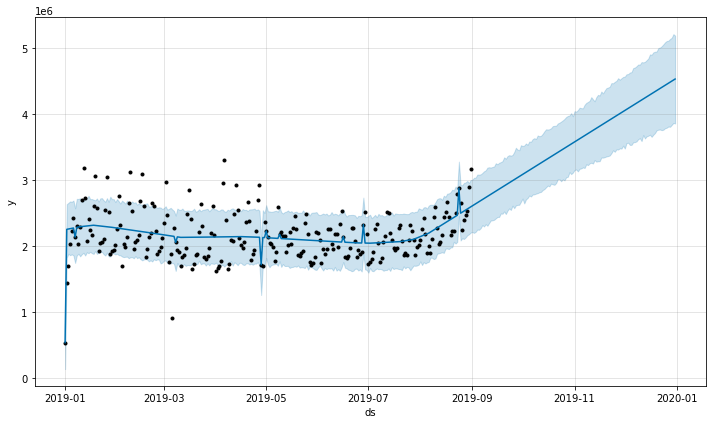

In [29]:
plot1 = model.plot(forecast)

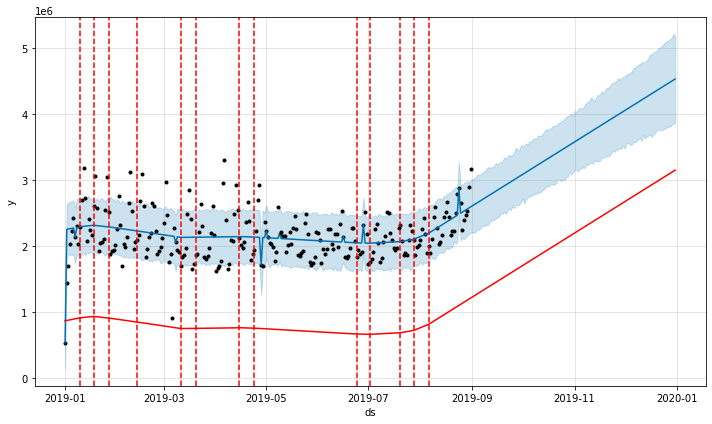

In [30]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

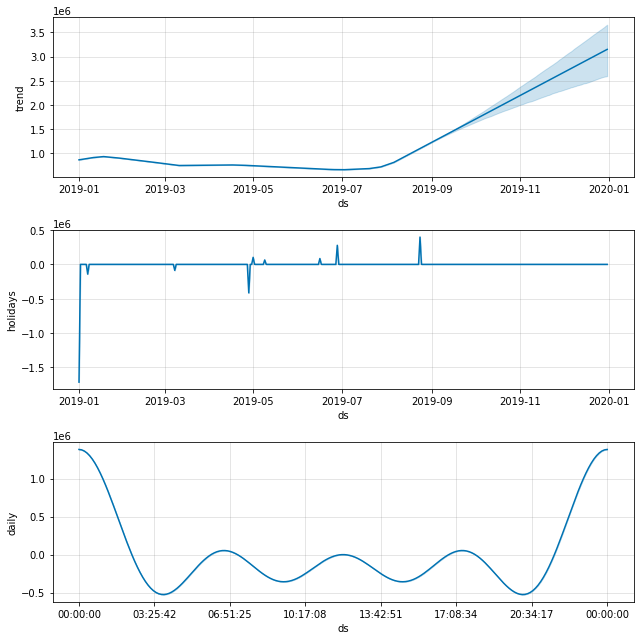

In [31]:
plot2 = model.plot_components(forecast)

In [32]:
# Смитрим на ошибки модели
cmp_df= forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(ts.set_index('ds'))
cmp_df['e']= cmp_df['y'] - cmp_df['yhat']
cmp_df['p']= 100*cmp_df['e'] / cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) - ', np.mean(abs(cmp_df[:-predictions]['p'])))
print('MAE (средняя абсолютная ошибка) - ', np.mean(abs(cmp_df[:-predictions]['e'])))

MAPE (средняя абсолютная ошибка в процентах) -  12.821300756944174
MAE (средняя абсолютная ошибка) -  276102.540069909


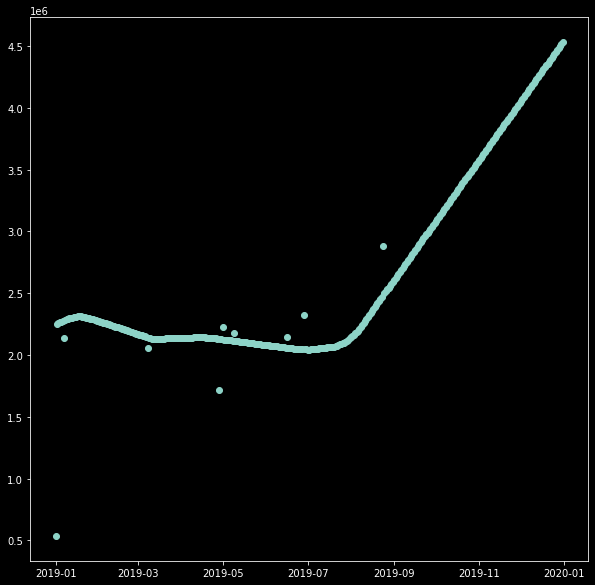

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib import style
from datetime import datetime
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib inline

#
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(10,10))
    plt.subplot(1,1,1)
    plt.plot(forecast['ds'], forecast['yhat'], linewidth=0,marker="o")

In [34]:
df_merge = forecast.merge(ts, on='ds', how = 'left')
df_merge

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,Різдво Христове (православне)_lower,Різдво Христове (православне)_upper,Трійця,Трійця_lower,Трійця_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2019-01-01,8.660819e+05,1.342412e+05,9.603849e+05,8.660819e+05,8.660819e+05,-3.314436e+05,-3.314436e+05,-3.314436e+05,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.346383e+05,536831.0
1,2019-01-02,8.710663e+05,1.822601e+06,2.634433e+06,8.710663e+05,8.710663e+05,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.253492e+06,1434828.0
2,2019-01-03,8.760508e+05,1.883049e+06,2.655547e+06,8.760508e+05,8.760508e+05,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.258476e+06,1701914.0
3,2019-01-04,8.810352e+05,1.861271e+06,2.677148e+06,8.810352e+05,8.810352e+05,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.263461e+06,2023772.0
4,2019-01-05,8.860196e+05,1.873958e+06,2.671150e+06,8.860196e+05,8.860196e+05,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.268445e+06,2228740.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,3.087023e+06,3.812718e+06,5.114973e+06,2.568987e+06,3.570000e+06,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.469448e+06,NaN
361,2019-12-28,3.102921e+06,3.808468e+06,5.140977e+06,2.577695e+06,3.592313e+06,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.485346e+06,NaN
362,2019-12-29,3.118819e+06,3.837580e+06,5.158972e+06,2.586657e+06,3.614268e+06,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.501244e+06,NaN
363,2019-12-30,3.134717e+06,3.867404e+06,5.213918e+06,2.591406e+06,3.640659e+06,1.382425e+06,1.382425e+06,1.382425e+06,1.382425e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.517142e+06,NaN


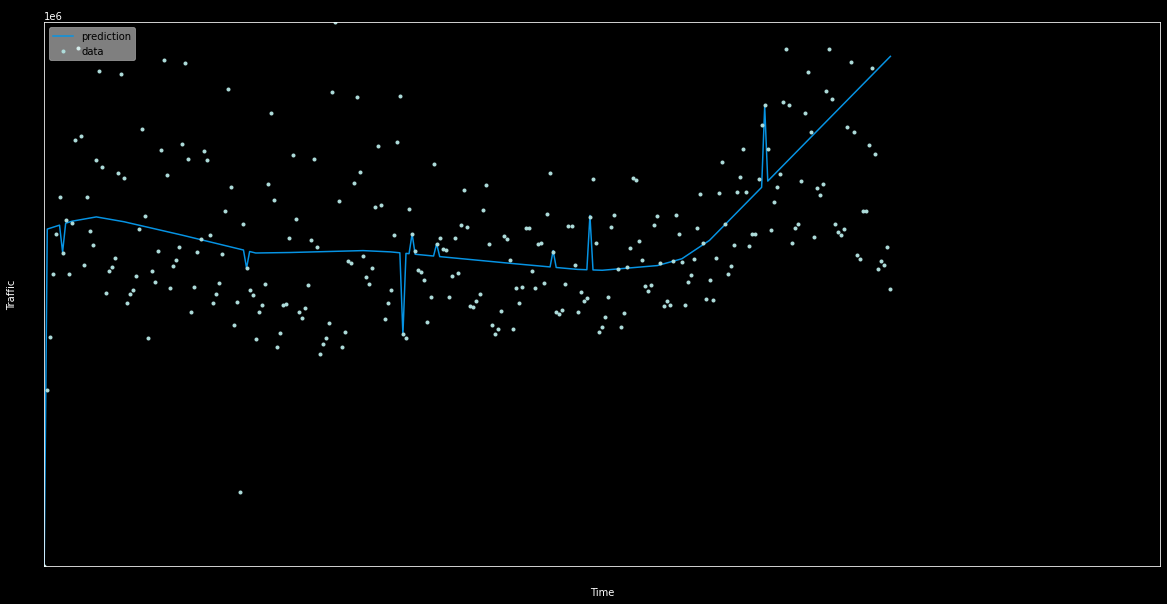

In [40]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(20,10))
    #creating a subplot 
    ax1 = fig.add_subplot(1,1,1)


    def animate(i):

        lines =  df_merge.iloc[0:int(i+277)] #   set the variable data to contain 0 to the (i+1)th row. I wanted only the prediction, so put 535.
        xs = []                         # I put  df_merge.iloc[0:int(i+535)] with a zero starting point, it understands EXACTLY what I want!
        ys = []
        zs = []
        for line in lines:
            if len(line)>1:
                xs = lines['ds']
                ys = lines['yhat']
                zs = lines['y']

        ax1.clear()
        
        ax1.set(title='Predicting the future traffic of my website',xlabel= "Time", ylabel='Traffic')
        ax1.axis(xmin= (df_merge['ds'].min()), xmax=(df_merge['ds'].max())) #XX I should add margin here too.
        ax1.axis(ymin= (df_merge['y'].min()-1), ymax=(df_merge['y'].max()+5)) #adding a bit of margin with -1 and +5

        ax1.plot(xs, ys, label='prediction', color='#0693e3')
        ax1.plot(xs, zs, marker = '.' ,linewidth = 0.0, label='data', color='#afdedc') #linewidth is not visible at 0.1, I change to 0.3
        ax1.legend(loc='upper left', frameon=True, framealpha = 0.5 )
        



writergif = animation.PillowWriter(fps=30) 

ani = animation.FuncAnimation(fig, animate, frames = (len(forecast)-len(ts)+34), interval=1) #the amount of frames had to be changed quite a lot to make a stop at the end.

plt.show()

writergif = animation.PillowWriter(fps=10, metadata=dict(artist='Arthur_Moreau')) 
ani.save('animation_video.gif', writer=writergif)

THE END